# Serbian Legal Named Entity Recognition (NER) Pipeline - 5-Fold Cross-Validation

This notebook implements 5-fold cross-validation for the Serbian Legal NER pipeline using the base BERT model (classla/bcms-bertic).

## Key Features
- **5-Fold Cross-Validation**: Robust evaluation across different data splits
- **Base BERT Architecture**: Uses classla/bcms-bertic for token classification
- **Sliding Window Tokenization**: Handles long sequences without truncation
- **Comprehensive Metrics**: Precision, recall, F1-score, and accuracy tracking
- **Statistical Analysis**: Mean and standard deviation across folds

## Entity Types
- **COURT**: Court institutions
- **DECISION_DATE**: Dates of legal decisions
- **CASE_NUMBER**: Case identifiers
- **CRIMINAL_ACT**: Criminal acts/charges
- **PROSECUTOR**: Prosecutor entities
- **DEFENDANT**: Defendant entities
- **JUDGE**: Judge names
- **REGISTRAR**: Court registrar
- **SANCTION**: Sanctions/penalties
- **SANCTION_TYPE**: Type of sanction
- **SANCTION_VALUE**: Value/duration of sanction
- **PROVISION**: Legal provisions
- **PROCEDURE_COSTS**: Legal procedure costs

## 1. Environment Setup and Dependencies

In [1]:
# Install required packages
!pip install transformers torch datasets tokenizers scikit-learn seqeval pandas numpy matplotlib seaborn tqdm

In [2]:
# Import shared modules
import sys
import os

sys.path.append('/shared/')


import importlib
import shared
import shared.model_utils
import shared.data_processing
import shared.dataset
import shared.evaluation
import shared.config
importlib.reload(shared.config)
importlib.reload(shared.data_processing)
importlib.reload(shared.dataset)
importlib.reload(shared.model_utils)
importlib.reload(shared.evaluation)
importlib.reload(shared)

# Import from shared modules
from shared import (
    # Configuration
    ENTITY_TYPES, BIO_LABELS,
    get_default_model_config, setup_environment,

    # Data processing
    LabelStudioToBIOConverter, load_labelstudio_data,
    analyze_labelstudio_data, validate_bio_examples,

    # Dataset
    NERDataset, tokenize_and_align_labels_with_sliding_window,
    create_huggingface_datasets,

    # Model utilities
    load_model_and_tokenizer, create_training_arguments, create_trainer,
    detailed_evaluation, setup_device_and_seed,
    PerClassMetricsCallback,

    # Comprehensive tracking
    analyze_entity_distribution_per_fold,
    generate_detailed_classification_report,
    # Aggregate functions
    create_aggregate_report_across_folds
)

# Standard imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold
import torch
from transformers import DataCollatorForTokenClassification, AutoTokenizer

# Setup device and random seed
device = setup_device_and_seed(42)

2025-10-05 14:23:18.434205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-05 14:23:18.434259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-05 14:23:18.435462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-05 14:23:18.442060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 14:23:19.374929: W tensorflow/compiler/tf2

🔧 Setup complete:
  PyTorch version: 2.1.1+cu121
  CUDA available: True
  CUDA device: NVIDIA RTX A4000
  Device: cuda
  Random seed: 42


## 2. Configuration and Environment Setup

In [3]:
# Setup environment and paths
env_setup = setup_environment(use_local=False, create_dirs=False)
paths = env_setup['paths']

# Model configuration
MODEL_NAME = "classla/bcms-bertic"
model_config = get_default_model_config()

# Output directory
OUTPUT_DIR = f"{paths['models_dir']}/bertic_base_5fold_cv"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"🔧 Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Entity types: {len(ENTITY_TYPES)}")
print(f"  BIO labels: {len(BIO_LABELS)}")

🔧 Environment setup (cloud):
  ✅ labelstudio_json: /datasets/annotations/annotations.json
  ✅ judgments_dir: /datasets/judgments
  ✅ labelstudio_files_dir: /datasets/judgments
  ❌ mlm_data_dir: /datasets/dapt-mlm
  ✅ models_dir: /storage/models
  ✅ logs_dir: /storage/logs
  ✅ results_dir: /storage/results
🔧 Configuration:
  Model: classla/bcms-bertic
  Output directory: /storage/models/bertic_base_5fold_cv
  Entity types: 16
  BIO labels: 33


## 3. Data Loading and Analysis

In [4]:
# Load LabelStudio data
labelstudio_data = load_labelstudio_data(paths['labelstudio_json'])

# Analyze the data
if labelstudio_data:
    analysis = analyze_labelstudio_data(labelstudio_data)
else:
    print("❌ No data loaded. Please check your paths.")
    exit()

✅ Loaded 225 annotated documents from /datasets/annotations/annotations.json
📊 Analysis Results:
Total documents: 225
Total annotations: 225
Unique entity types: 14

Entity distribution:
  DEFENDANT: 1240
  PROVISION_MATERIAL: 1177
  CRIMINAL_ACT: 792
  PROVISION_PROCEDURAL: 686
  REGISTRAR: 460
  COURT: 458
  JUDGE: 451
  PROSECUTOR: 395
  DECISION_DATE: 359
  SANCTION_TYPE: 248
  SANCTION_VALUE: 241
  VERDICT: 238
  PROCEDURE_COSTS: 231
  CASE_NUMBER: 225


## 4. Data Preprocessing and BIO Conversion

In [5]:
# Convert LabelStudio data to BIO format
converter = LabelStudioToBIOConverter(
    judgments_dir=paths['judgments_dir'],
    labelstudio_files_dir=paths.get('labelstudio_files_dir')
)

bio_examples = converter.convert_to_bio(labelstudio_data)
print(f"✅ Converted {len(bio_examples)} examples to BIO format")

# Validate BIO examples
valid_examples, stats = validate_bio_examples(bio_examples)
print(f"📊 Validation complete: {stats['valid_examples']} valid examples")

✅ Converted 225 examples to BIO format
📊 BIO Validation Results:
Total examples: 225
Valid examples: 225
Invalid examples: 0
Empty examples: 0
📊 Validation complete: 225 valid examples


## 5. Dataset Preparation

In [6]:
# Create NER dataset
ner_dataset = NERDataset(valid_examples)
prepared_examples = ner_dataset.prepare_for_training()

print(f"📊 Dataset statistics:")
print(f"  Number of unique labels: {ner_dataset.get_num_labels()}")
print(f"  Prepared examples: {len(prepared_examples)}")

# Get label statistics
label_stats = ner_dataset.get_label_statistics()
print(f"  Total tokens: {label_stats['total_tokens']}")
print(f"  Entity types found: {len(label_stats['entity_counts'])}")

📊 Dataset statistics:
  Number of unique labels: 29
  Prepared examples: 225
  Total tokens: 232475
  Entity types found: 14


## 6. K-Fold Cross-Validation Setup

In [7]:
# Set up 5-fold cross-validation
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Convert to numpy array for easier indexing
examples_array = np.array(prepared_examples, dtype=object)

print(f"Setting up {N_FOLDS}-fold cross-validation")
print(f"Total examples: {len(prepared_examples)}")
print(f"Examples per fold (approx): {len(prepared_examples) // N_FOLDS}")

# Load tokenizer (will be used across all folds)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"\nLoaded tokenizer for {MODEL_NAME}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

# Store results from all folds
fold_results = []

Setting up 5-fold cross-validation
Total examples: 225
Examples per fold (approx): 45

Loaded tokenizer for classla/bcms-bertic
Tokenizer vocab size: 32000


## 7. K-Fold Cross-Validation Helper Functions

In [8]:
# ============================================================================
# K-FOLD CROSS-VALIDATION HELPER FUNCTIONS
# ============================================================================

def prepare_fold_data(train_examples, val_examples, tokenizer, ner_dataset):
    """
    Prepare training and validation datasets for a specific fold.

    Args:
        train_examples: Training examples for this fold
        val_examples: Validation examples for this fold
        tokenizer: Tokenizer instance
        ner_dataset: NER dataset instance

    Returns:
        tuple: (train_dataset, val_dataset, data_collator)
    """
    # Tokenize datasets with sliding window
    train_tokenized = tokenize_and_align_labels_with_sliding_window(
        train_examples, tokenizer, ner_dataset.label_to_id,
        max_length=model_config['max_length'], stride=model_config['stride']
    )

    val_tokenized = tokenize_and_align_labels_with_sliding_window(
        val_examples, tokenizer, ner_dataset.label_to_id,
        max_length=model_config['max_length'], stride=model_config['stride']
    )

    # Create HuggingFace datasets
    train_dataset, val_dataset, _ = create_huggingface_datasets(
        train_tokenized, val_tokenized, val_tokenized  # Using val as placeholder for test
    )

    # Data collator
    data_collator = DataCollatorForTokenClassification(
        tokenizer=tokenizer,
        padding=True,
        return_tensors="pt"
    )

    return train_dataset, val_dataset, data_collator

print("✅ K-fold helper functions defined successfully!")

✅ K-fold helper functions defined successfully!


In [9]:
def create_model_and_trainer(fold_num, train_dataset, val_dataset, data_collator, tokenizer, ner_dataset, device):
    """
    Create model and trainer for a specific fold with comprehensive metrics tracking.

    Args:
        fold_num: Current fold number
        train_dataset: Training dataset for this fold
        val_dataset: Validation dataset for this fold
        data_collator: Data collator
        tokenizer: Tokenizer instance
        ner_dataset: NER dataset instance
        device: Device to use (cuda/cpu)

    Returns:
        tuple: (model, trainer, metrics_callback, fold_output_dir)
    """
    # Create fold-specific output directory
    fold_output_dir = f"{OUTPUT_DIR}/fold_{fold_num}"
    import os
    os.makedirs(fold_output_dir, exist_ok=True)

    # Load fresh model for this fold
    model, _ = load_model_and_tokenizer(
        MODEL_NAME,
        ner_dataset.get_num_labels(),
        ner_dataset.id_to_label,
        ner_dataset.label_to_id
    )

    # Move model to device
    model.to(device)

    # Create training arguments for this fold
    training_args = create_training_arguments(
        output_dir=fold_output_dir,
        num_epochs=model_config['num_epochs'],
        batch_size=model_config['batch_size'],
        learning_rate=model_config['learning_rate'],
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=50,
        eval_steps=100,
        save_steps=500,
        early_stopping_patience=3
    )

    # Create metrics callback for comprehensive tracking
    metrics_callback = PerClassMetricsCallback(id_to_label=ner_dataset.id_to_label)

    # Create trainer with metrics callback
    trainer = create_trainer(
        model=model,
        training_args=training_args,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        id_to_label=ner_dataset.id_to_label,
        early_stopping_patience=3,
        additional_callbacks=[metrics_callback]
    )

    print(f"Trainer initialized for fold {fold_num} with comprehensive metrics tracking")
    return model, trainer, metrics_callback, fold_output_dir

print("✅ Model and trainer creation function defined successfully!")

✅ Model and trainer creation function defined successfully!


In [10]:
def train_and_evaluate_fold(fold_num, trainer, val_dataset, ner_dataset):
    """
    Train and evaluate a model for a specific fold.

    Args:
        fold_num: Current fold number
        trainer: Trainer instance
        val_dataset: Validation dataset for this fold
        ner_dataset: NER dataset instance

    Returns:
        dict: Fold results including metrics
    """
    print(f"\n🏋️  Training fold {fold_num}...")

    # Train the model
    trainer.train()

    print(f"💾 Saving model for fold {fold_num}...")
    trainer.save_model()

    # Evaluate on validation set
    print(f"📊 Evaluating fold {fold_num}...")
    eval_results = detailed_evaluation(
        trainer, val_dataset, f"Fold {fold_num} Validation", ner_dataset.id_to_label
    )

    # Extract metrics
    fold_result = {
        'fold': fold_num,
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f1': eval_results['f1'],
        'accuracy': eval_results['accuracy'],
        'true_predictions': eval_results['true_predictions'],
        'true_labels': eval_results['true_labels']
    }

    print(f"\nFold {fold_num} completed successfully!")
    return fold_result

print("✅ Training and evaluation helper function defined successfully!")

✅ Training and evaluation helper function defined successfully!


## 8. K-Fold Cross-Validation Training Loop

In [11]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Main K-Fold Cross-Validation Loop
print(f"\n{'='*80}")
print(f"STARTING {N_FOLDS}-FOLD CROSS-VALIDATION")
print(f"{'='*80}")
print(f"Total examples: {len(examples_array)}")
print(f"Model: {MODEL_NAME}")
print(f"Device: {device}")

# Execute K-Fold training
for fold_num, (train_idx, val_idx) in enumerate(kfold.split(examples_array), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold_num}/{N_FOLDS}")
    print(f"{'='*80}")
    print(f"Train indices: {len(train_idx)}, Val indices: {len(val_idx)}")

    # Get fold data
    train_examples = examples_array[train_idx].tolist()
    val_examples = examples_array[val_idx].tolist()

    print(f"Training examples: {len(train_examples)}")
    print(f"Validation examples: {len(val_examples)}")

    # Analyze entity distributions for this fold
    print(f"\n📊 Analyzing entity distributions...")
    train_dist = analyze_entity_distribution_per_fold(train_examples, f"Fold {fold_num} - Training")
    val_dist = analyze_entity_distribution_per_fold(val_examples, f"Fold {fold_num} - Validation")

    # Prepare data for this fold
    print(f"\n🔤 Preparing data for fold {fold_num}...")
    train_dataset, val_dataset, data_collator = prepare_fold_data(
        train_examples, val_examples, tokenizer, ner_dataset
    )

    print(f"📦 Fold {fold_num} datasets:")
    print(f"  Training: {len(train_dataset)} examples")
    print(f"  Validation: {len(val_dataset)} examples")

    # Create model and trainer for this fold
    print(f"\n🤖 Creating model and trainer for fold {fold_num}...")
    model, trainer, metrics_callback, fold_output_dir = create_model_and_trainer(
        fold_num, train_dataset, val_dataset, data_collator, tokenizer, ner_dataset, device
    )

    # Train and evaluate this fold
    fold_result = train_and_evaluate_fold(fold_num, trainer, val_dataset, ner_dataset)
    
    # Get predictions and labels for aggregation
    print(f"\n📊 Getting predictions for fold {fold_num}...")
    predictions, labels, _ = trainer.predict(val_dataset)
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to label names
    true_labels = [[ner_dataset.id_to_label[l] for l in label if l != -100] for label in labels]
    pred_labels = [[ner_dataset.id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                   for prediction, label in zip(predictions, labels)]
    
    # Generate per-class metrics and confusion matrix for this fold
    from sklearn.metrics import confusion_matrix
    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in pred_labels for label in seq]
    all_labels = sorted(list(set(flat_true + flat_pred)))
    cm = confusion_matrix(flat_true, flat_pred, labels=all_labels)
    
    # Generate classification report for this fold
    per_class_metrics = generate_detailed_classification_report(
        true_labels, pred_labels, fold_output_dir, fold_num, "Validation"
    )
    
    # Store comprehensive data for aggregation
    fold_result['distributions'] = {'train': train_dist, 'val': val_dist}
    fold_result['per_class_metrics'] = per_class_metrics
    fold_result['confusion_matrix'] = cm
    fold_result['labels'] = all_labels
    fold_result['training_history'] = metrics_callback.get_training_history()
    fold_results.append(fold_result)

    # Clean up to free memory
    del model, trainer, train_dataset, val_dataset, metrics_callback
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print(f"\n✅ Fold {fold_num} completed!")
    print(f"   Precision: {fold_result['precision']:.4f}")
    print(f"   Recall: {fold_result['recall']:.4f}")
    print(f"   F1-Score: {fold_result['f1']:.4f}")
    print(f"   Accuracy: {fold_result['accuracy']:.4f}")

print(f"\n{'='*80}")
print(f"K-FOLD CROSS-VALIDATION COMPLETED!")
print(f"{'='*80}")

Using device: cuda

STARTING 5-FOLD CROSS-VALIDATION
Total examples: 225
Model: classla/bcms-bertic
Device: cuda

FOLD 1/5
Train indices: 180, Val indices: 45
Training examples: 180
Validation examples: 45

📊 Analyzing entity distributions...

📊 Entity Distribution - Fold 1 - Training
Entity Type                         Count      Percentage
------------------------------------------------------------
PROVISION_MATERIAL                   7320          35.29%
PROVISION_PROCEDURAL                 3210          15.48%
CRIMINAL_ACT                         2252          10.86%
COURT                                1641           7.91%
DEFENDANT                            1445           6.97%
SANCTION_VALUE                        956           4.61%
JUDGE                                 734           3.54%
REGISTRAR                             731           3.52%
VERDICT                               573           2.76%
PROSECUTOR                            510           2.46%
SANCTION_TYPE  

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 801
📊 Validation dataset size: 214
Trainer initialized for fold 1 with comprehensive metrics tracking

🏋️  Training fold 1...


wandb: Currently logged in as: pericapero1 (pericapero1-faculty-of-). Use `wandb login --relogin` to force relogin


You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,1.987100,0.825533,0.000000,0.000000,0.000000,0.881149
200,0.395800,0.342356,0.340129,0.167548,0.224504,0.916324
300,0.228800,0.207725,0.369407,0.375264,0.372313,0.955560
400,0.142400,0.143054,0.622055,0.697674,0.657698,0.973650
500,0.099300,0.102222,0.785231,0.798097,0.791612,0.981236
600,0.065800,0.097212,0.778757,0.840909,0.808640,0.980641
700,0.054000,0.083654,0.814335,0.864693,0.838759,0.982788
800,0.044100,0.080846,0.813459,0.868922,0.840276,0.984278


💾 Saving model for fold 1...
📊 Evaluating fold 1...



📊 Fold 1 Validation Set Results:
  Precision: 0.7852
  Recall: 0.7981
  F1-score: 0.7916
  Accuracy: 0.9812

Fold 1 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       1.00      0.31      0.47        45
               B-COURT       0.94      0.98      0.96        99
        B-CRIMINAL_ACT       0.93      0.97      0.95       215
       B-DECISION_DATE       0.79      0.95      0.87        81
           B-DEFENDANT       0.77      0.70      0.74       332
               B-JUDGE       0.78      0.78      0.78        94
     B-PROCEDURE_COSTS       0.94      1.00      0.97        67
          B-PROSECUTOR       1.00      0.01      0.02       100
  B-PROVISION_MATERIAL       0.93      0.94      0.94       347
B-PROVISION_PROCEDURAL       0.93      0.98      0.95       182
           B-REGISTRAR       0.70      0.94      0.80       102
       B-SANCTION_TYPE       0.82      0.87      0.85        76
 


Validation - Fold 1 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     1.0000    0.3111    0.4746        45
               B-COURT     0.9417    0.9798    0.9604        99
        B-CRIMINAL_ACT     0.9289    0.9721    0.9500       215
       B-DECISION_DATE     0.7938    0.9506    0.8652        81
           B-DEFENDANT     0.7715    0.7018    0.7350       332
               B-JUDGE     0.7849    0.7766    0.7807        94
     B-PROCEDURE_COSTS     0.9437    1.0000    0.9710        67
          B-PROSECUTOR     1.0000    0.0100    0.0198       100
  B-PROVISION_MATERIAL     0.9341    0.9395    0.9368       347
B-PROVISION_PROCEDURAL     0.9271    0.9780    0.9519       182
           B-REGISTRAR     0.6957    0.9412    0.8000       102
       B-SANCTION_TYPE     0.8250    0.8684    0.8462        76
      B-SANCTION_VALUE     1.0000    0.6575    0.7934        73
             B-VERDICT     0.9483    0.7746 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 820
📊 Validation dataset size: 195
Trainer initialized for fold 2 with comprehensive metrics tracking

🏋️  Training fold 2...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.353000,1.050250,0.000000,0.000000,0.000000,0.877940
200,0.484100,0.385958,0.280864,0.156268,0.200809,0.912773
300,0.245300,0.216162,0.412870,0.414997,0.413931,0.955997
400,0.147400,0.137468,0.765037,0.779050,0.771980,0.978633
500,0.096800,0.108610,0.811924,0.857470,0.834076,0.982384
600,0.066200,0.093849,0.823940,0.878649,0.850416,0.982892
700,0.056200,0.086667,0.851891,0.915283,0.882450,0.983943
800,0.044900,0.084958,0.867281,0.916428,0.891177,0.985266


💾 Saving model for fold 2...
📊 Evaluating fold 2...



📊 Fold 2 Validation Set Results:
  Precision: 0.8119
  Recall: 0.8575
  F1-score: 0.8341
  Accuracy: 0.9824

Fold 2 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       1.00      0.60      0.75        45
               B-COURT       0.96      0.99      0.97        96
        B-CRIMINAL_ACT       0.92      0.92      0.92       214
       B-DECISION_DATE       0.87      0.91      0.89        76
           B-DEFENDANT       0.80      0.88      0.84       277
               B-JUDGE       0.86      0.78      0.82        93
     B-PROCEDURE_COSTS       0.82      0.89      0.85        53
          B-PROSECUTOR       0.85      0.27      0.40        83
  B-PROVISION_MATERIAL       0.90      0.97      0.93       317
B-PROVISION_PROCEDURAL       0.97      0.93      0.95       191
           B-REGISTRAR       0.86      0.93      0.89        96
       B-SANCTION_TYPE       0.96      0.83      0.89        64
 


Validation - Fold 2 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     1.0000    0.6000    0.7500        45
               B-COURT     0.9596    0.9896    0.9744        96
        B-CRIMINAL_ACT     0.9245    0.9159    0.9202       214
       B-DECISION_DATE     0.8734    0.9079    0.8903        76
           B-DEFENDANT     0.8000    0.8809    0.8385       277
               B-JUDGE     0.8588    0.7849    0.8202        93
     B-PROCEDURE_COSTS     0.8246    0.8868    0.8545        53
          B-PROSECUTOR     0.8462    0.2651    0.4037        83
  B-PROVISION_MATERIAL     0.8983    0.9748    0.9349       317
B-PROVISION_PROCEDURAL     0.9674    0.9319    0.9493       191
           B-REGISTRAR     0.8641    0.9271    0.8945        96
       B-SANCTION_TYPE     0.9636    0.8281    0.8908        64
      B-SANCTION_VALUE     1.0000    0.6452    0.7843        62
             B-VERDICT     1.0000    0.9091 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 823
📊 Validation dataset size: 192
Trainer initialized for fold 3 with comprehensive metrics tracking

🏋️  Training fold 3...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.338000,1.047741,0.000000,0.000000,0.000000,0.876917
200,0.472100,0.395833,0.276119,0.152532,0.196510,0.912341
300,0.238800,0.230176,0.419554,0.399293,0.409173,0.954053
400,0.148100,0.145149,0.701370,0.753828,0.726653,0.977699
500,0.103900,0.114973,0.682189,0.836867,0.751653,0.977899
600,0.067200,0.090892,0.795640,0.859835,0.826493,0.983915
700,0.054900,0.082525,0.796228,0.895171,0.842806,0.985078
800,0.046700,0.081023,0.811540,0.902827,0.854753,0.984806


💾 Saving model for fold 3...
📊 Evaluating fold 3...



📊 Fold 3 Validation Set Results:
  Precision: 0.6822
  Recall: 0.8369
  F1-score: 0.7517
  Accuracy: 0.9779

Fold 3 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       1.00      0.52      0.69        46
               B-COURT       0.94      0.90      0.92       100
        B-CRIMINAL_ACT       0.86      0.94      0.90       180
       B-DECISION_DATE       0.62      1.00      0.76        79
           B-DEFENDANT       0.46      0.99      0.63       244
               B-JUDGE       0.77      0.73      0.75        95
     B-PROCEDURE_COSTS       0.87      0.94      0.90        69
          B-PROSECUTOR       1.00      0.01      0.02        87
  B-PROVISION_MATERIAL       0.95      0.98      0.97       304
B-PROVISION_PROCEDURAL       0.98      0.97      0.97       174
           B-REGISTRAR       0.74      0.90      0.81        97
       B-SANCTION_TYPE       0.85      0.68      0.75        77
 


Validation - Fold 3 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     1.0000    0.5217    0.6857        46
               B-COURT     0.9375    0.9000    0.9184       100
        B-CRIMINAL_ACT     0.8579    0.9389    0.8966       180
       B-DECISION_DATE     0.6172    1.0000    0.7633        79
           B-DEFENDANT     0.4590    0.9877    0.6268       244
               B-JUDGE     0.7667    0.7263    0.7459        95
     B-PROCEDURE_COSTS     0.8667    0.9420    0.9028        69
          B-PROSECUTOR     1.0000    0.0115    0.0227        87
  B-PROVISION_MATERIAL     0.9521    0.9803    0.9660       304
B-PROVISION_PROCEDURAL     0.9769    0.9713    0.9741       174
           B-REGISTRAR     0.7436    0.8969    0.8131        97
       B-SANCTION_TYPE     0.8525    0.6753    0.7536        77
      B-SANCTION_VALUE     0.9074    0.6712    0.7717        73
             B-VERDICT     0.8868    0.7966 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 810
📊 Validation dataset size: 205
Trainer initialized for fold 4 with comprehensive metrics tracking

🏋️  Training fold 4...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.359800,1.005904,0.000000,0.000000,0.000000,0.895692
200,0.445600,0.335505,0.317530,0.164854,0.217031,0.924727
300,0.253300,0.203983,0.385076,0.404694,0.394641,0.957675
400,0.159400,0.128436,0.734479,0.758443,0.746269,0.980616
500,0.101500,0.084891,0.784048,0.827132,0.805014,0.986016
600,0.086400,0.072336,0.809625,0.876359,0.841671,0.987794
700,0.060100,0.065686,0.814315,0.898683,0.854422,0.987923
800,0.050300,0.065515,0.822188,0.907842,0.862894,0.988328


💾 Saving model for fold 4...
📊 Evaluating fold 4...



📊 Fold 4 Validation Set Results:
  Precision: 0.7840
  Recall: 0.8271
  F1-score: 0.8050
  Accuracy: 0.9860

Fold 4 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       1.00      0.27      0.43        44
               B-COURT       0.96      0.99      0.97        97
        B-CRIMINAL_ACT       0.95      0.99      0.97       214
       B-DECISION_DATE       0.84      0.92      0.87        83
           B-DEFENDANT       0.73      0.87      0.80       316
               B-JUDGE       0.89      0.68      0.77        95
     B-PROCEDURE_COSTS       0.76      0.92      0.83        49
          B-PROSECUTOR       0.86      0.28      0.42        68
  B-PROVISION_MATERIAL       0.95      0.99      0.97       312
B-PROVISION_PROCEDURAL       0.96      0.96      0.96       166
           B-REGISTRAR       0.76      0.91      0.83        97
       B-SANCTION_TYPE       0.94      0.65      0.77        69
 


Validation - Fold 4 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     1.0000    0.2727    0.4286        44
               B-COURT     0.9600    0.9897    0.9746        97
        B-CRIMINAL_ACT     0.9548    0.9860    0.9701       214
       B-DECISION_DATE     0.8352    0.9157    0.8736        83
           B-DEFENDANT     0.7321    0.8734    0.7965       316
               B-JUDGE     0.8904    0.6842    0.7738        95
     B-PROCEDURE_COSTS     0.7627    0.9184    0.8333        49
          B-PROSECUTOR     0.8636    0.2794    0.4222        68
  B-PROVISION_MATERIAL     0.9508    0.9904    0.9702       312
B-PROVISION_PROCEDURAL     0.9639    0.9639    0.9639       166
           B-REGISTRAR     0.7586    0.9072    0.8263        97
       B-SANCTION_TYPE     0.9375    0.6522    0.7692        69
      B-SANCTION_VALUE     0.9750    0.5909    0.7358        66
             B-VERDICT     0.9400    0.7833 

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
🏋️  Created trainer with early stopping (patience: 3)
📊 Additional callbacks: PerClassMetricsCallback
📊 Training dataset size: 806
📊 Validation dataset size: 209
Trainer initialized for fold 5 with comprehensive metrics tracking

🏋️  Training fold 5...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,2.365300,0.986269,0.000000,0.000000,0.000000,0.896915
200,0.461700,0.331014,0.297085,0.148626,0.198131,0.926122
300,0.249500,0.189046,0.353355,0.366237,0.359681,0.959989
400,0.149700,0.124850,0.712900,0.700505,0.706648,0.980445
500,0.107800,0.089453,0.785443,0.810993,0.798013,0.984330
600,0.069600,0.073794,0.784021,0.853057,0.817083,0.984741
700,0.055300,0.063893,0.820136,0.877173,0.847696,0.987095
800,0.046200,0.063972,0.796781,0.888390,0.840095,0.986668


💾 Saving model for fold 5...
📊 Evaluating fold 5...



📊 Fold 5 Validation Set Results:
  Precision: 0.7854
  Recall: 0.8110
  F1-score: 0.7980
  Accuracy: 0.9843

Fold 5 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       1.00      0.58      0.74        43
               B-COURT       0.97      0.92      0.95       103
        B-CRIMINAL_ACT       0.94      0.96      0.95       196
       B-DECISION_DATE       0.82      0.97      0.89        77
           B-DEFENDANT       0.76      0.83      0.79       306
               B-JUDGE       0.82      0.62      0.71        98
     B-PROCEDURE_COSTS       0.84      0.90      0.87        72
          B-PROSECUTOR       0.00      0.00      0.00       123
  B-PROVISION_MATERIAL       0.93      0.98      0.95       282
B-PROVISION_PROCEDURAL       0.97      0.96      0.97       198
           B-REGISTRAR       0.64      0.95      0.77        97
       B-SANCTION_TYPE       0.82      0.85      0.84        55
 


Validation - Fold 5 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     1.0000    0.5814    0.7353        43
               B-COURT     0.9694    0.9223    0.9453       103
        B-CRIMINAL_ACT     0.9353    0.9592    0.9471       196
       B-DECISION_DATE     0.8152    0.9740    0.8876        77
           B-DEFENDANT     0.7552    0.8268    0.7894       306
               B-JUDGE     0.8243    0.6224    0.7093        98
     B-PROCEDURE_COSTS     0.8442    0.9028    0.8725        72
          B-PROSECUTOR     0.0000    0.0000    0.0000       123
  B-PROVISION_MATERIAL     0.9264    0.9823    0.9535       282
B-PROVISION_PROCEDURAL     0.9744    0.9596    0.9669       198
           B-REGISTRAR     0.6434    0.9485    0.7667        97
       B-SANCTION_TYPE     0.8246    0.8545    0.8393        55
      B-SANCTION_VALUE     0.9787    0.8214    0.8932        56
             B-VERDICT     0.9310    0.8060 

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

## 9. Generate Aggregate Report Across All Folds

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd1d0756650, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=7097849d-14ca-4437-a937-b136dcf88229>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given


GENERATING AGGREGATE REPORT ACROSS ALL 5 FOLDS

CREATING AGGREGATE REPORT ACROSS 5 FOLDS

📊 Plotting entity distribution across folds...

PLOTTING ENTITY DISTRIBUTION ACROSS 5 FOLDS


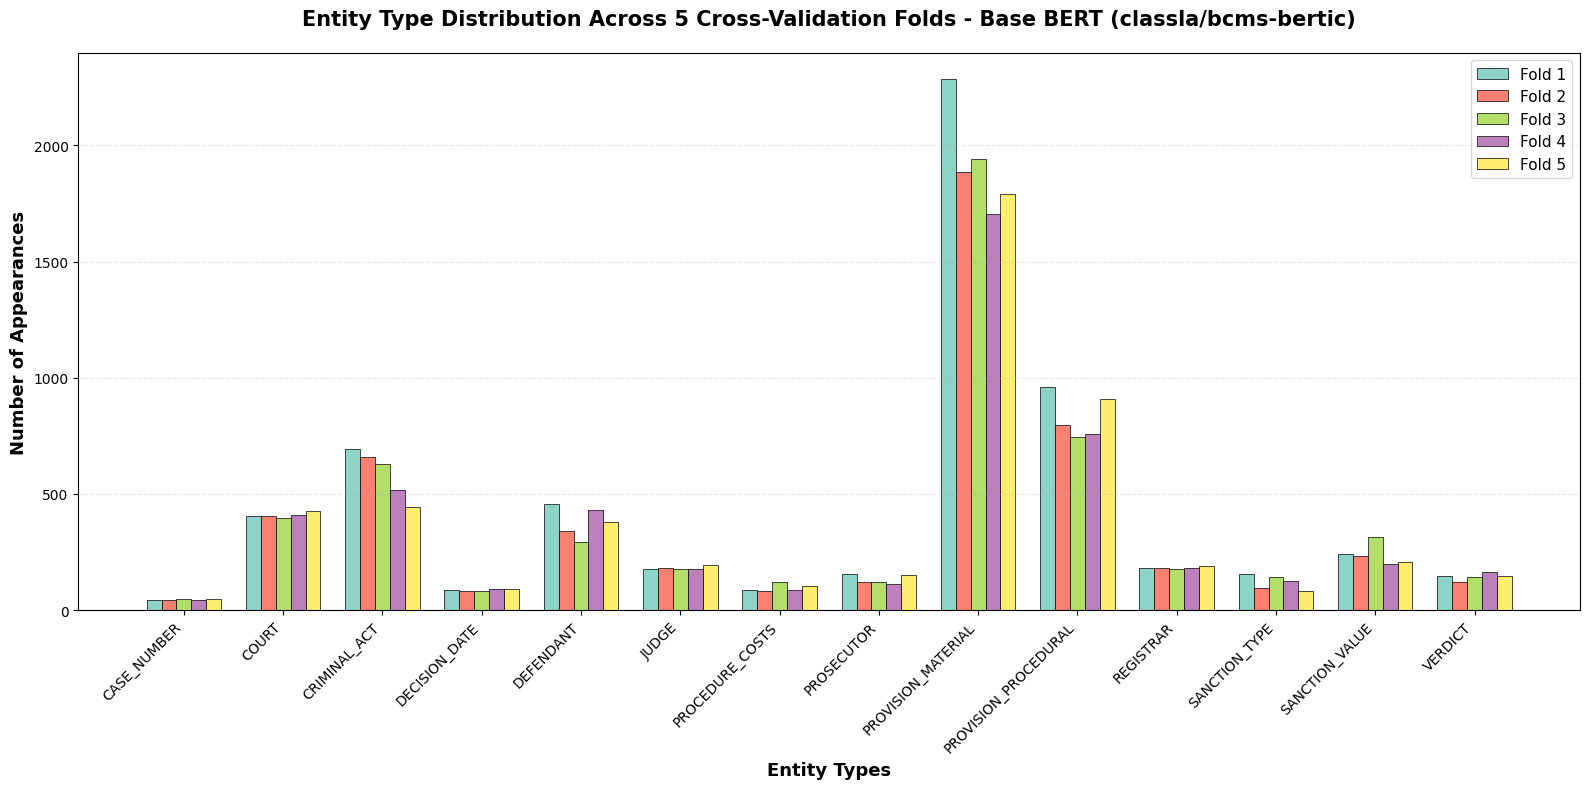

✅ Entity distribution across folds visualization displayed

📉 Plotting training and validation loss...

PLOTTING TRAINING AND VALIDATION LOSS ACROSS 5 FOLDS


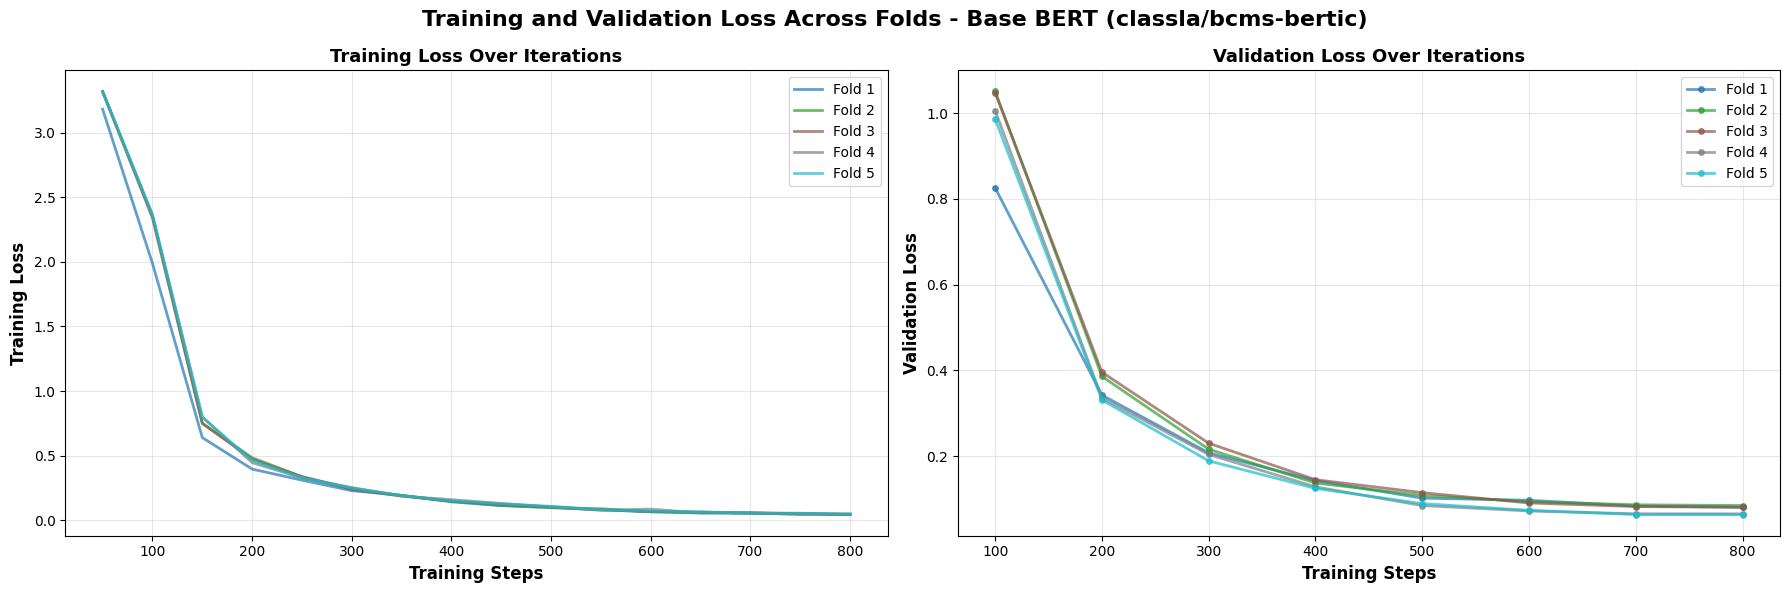

✅ Training and validation loss visualization displayed

📈 Plotting macro/micro-averaged metrics over iterations...

PLOTTING MACRO/MICRO-AVERAGED METRICS OVER ITERATIONS
📊 Aligning 8 evaluation points across 5 folds


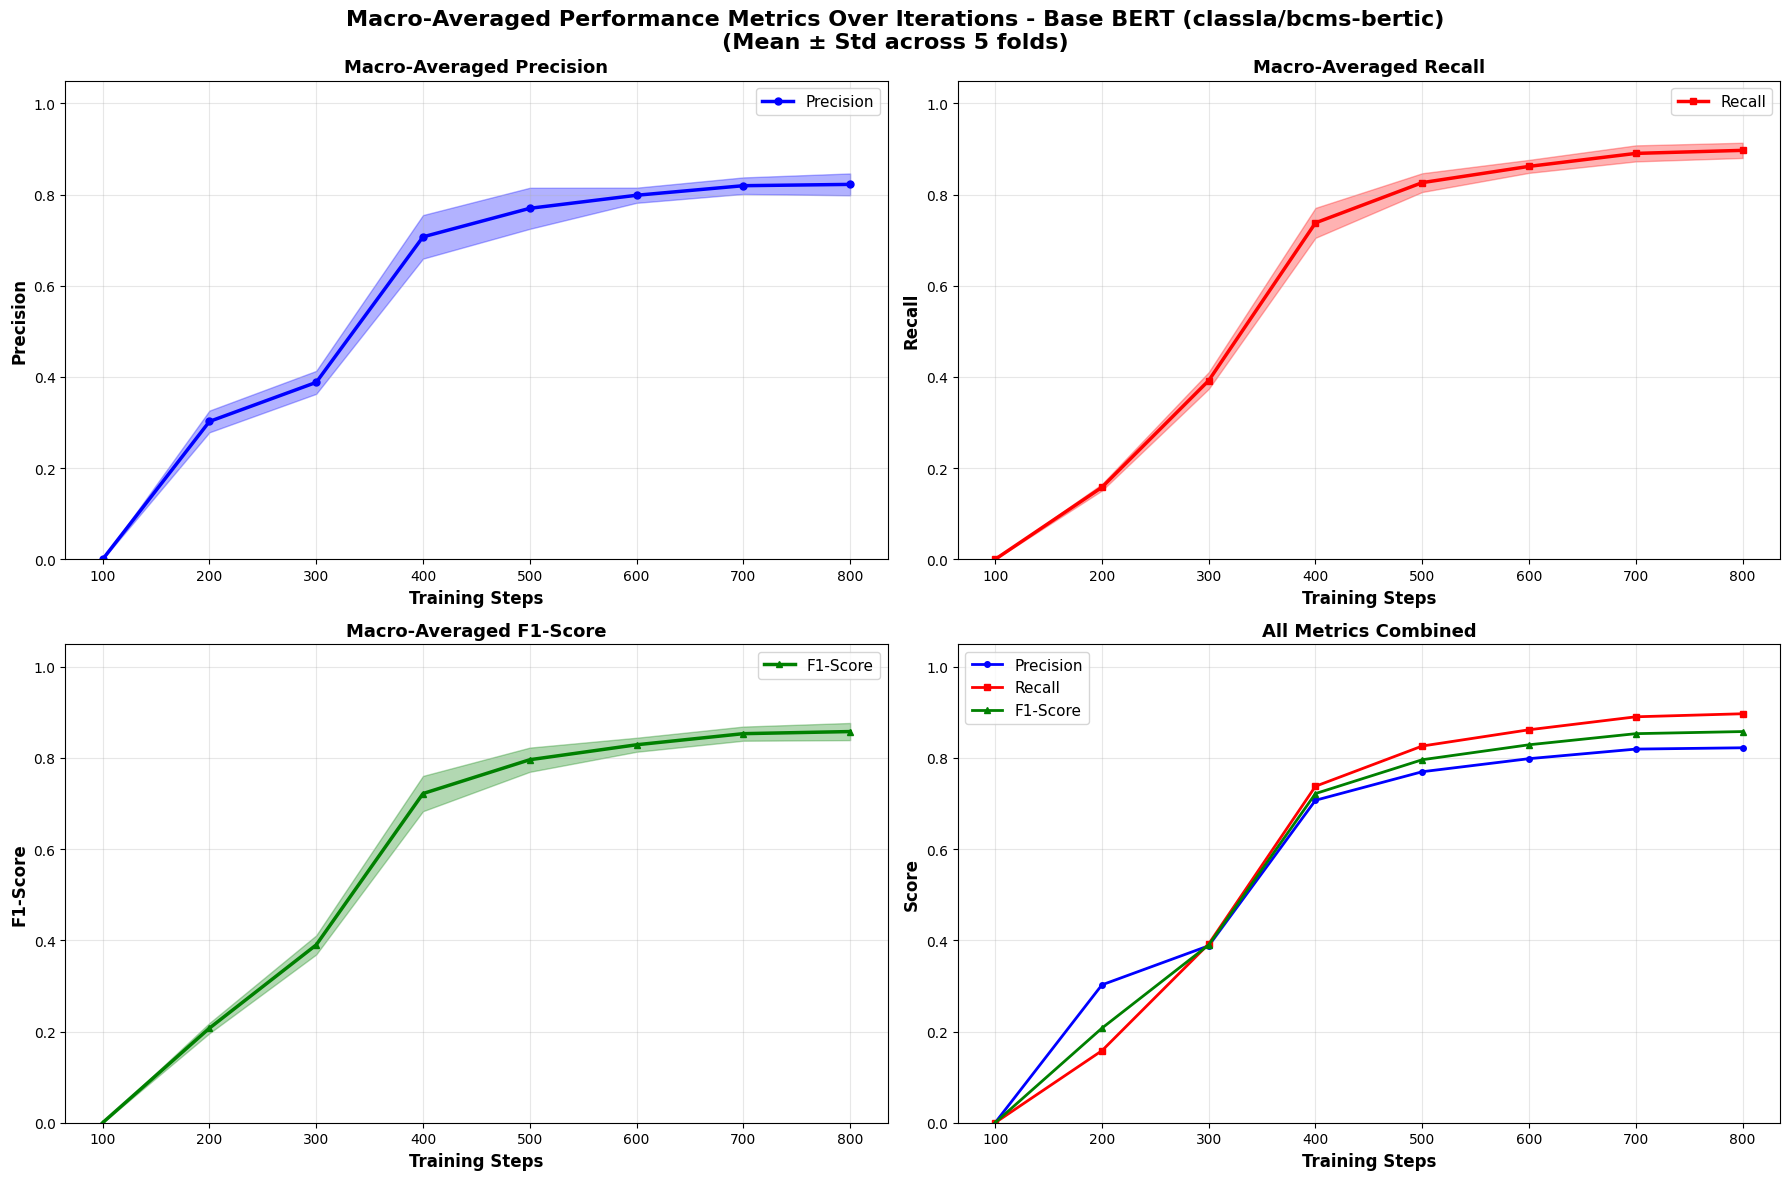

✅ Macro/micro-averaged metrics visualization displayed

📈 Aggregating training metrics...

AGGREGATING TRAINING METRICS ACROSS 5 FOLDS
📊 Aligning 8 evaluation points across 5 folds


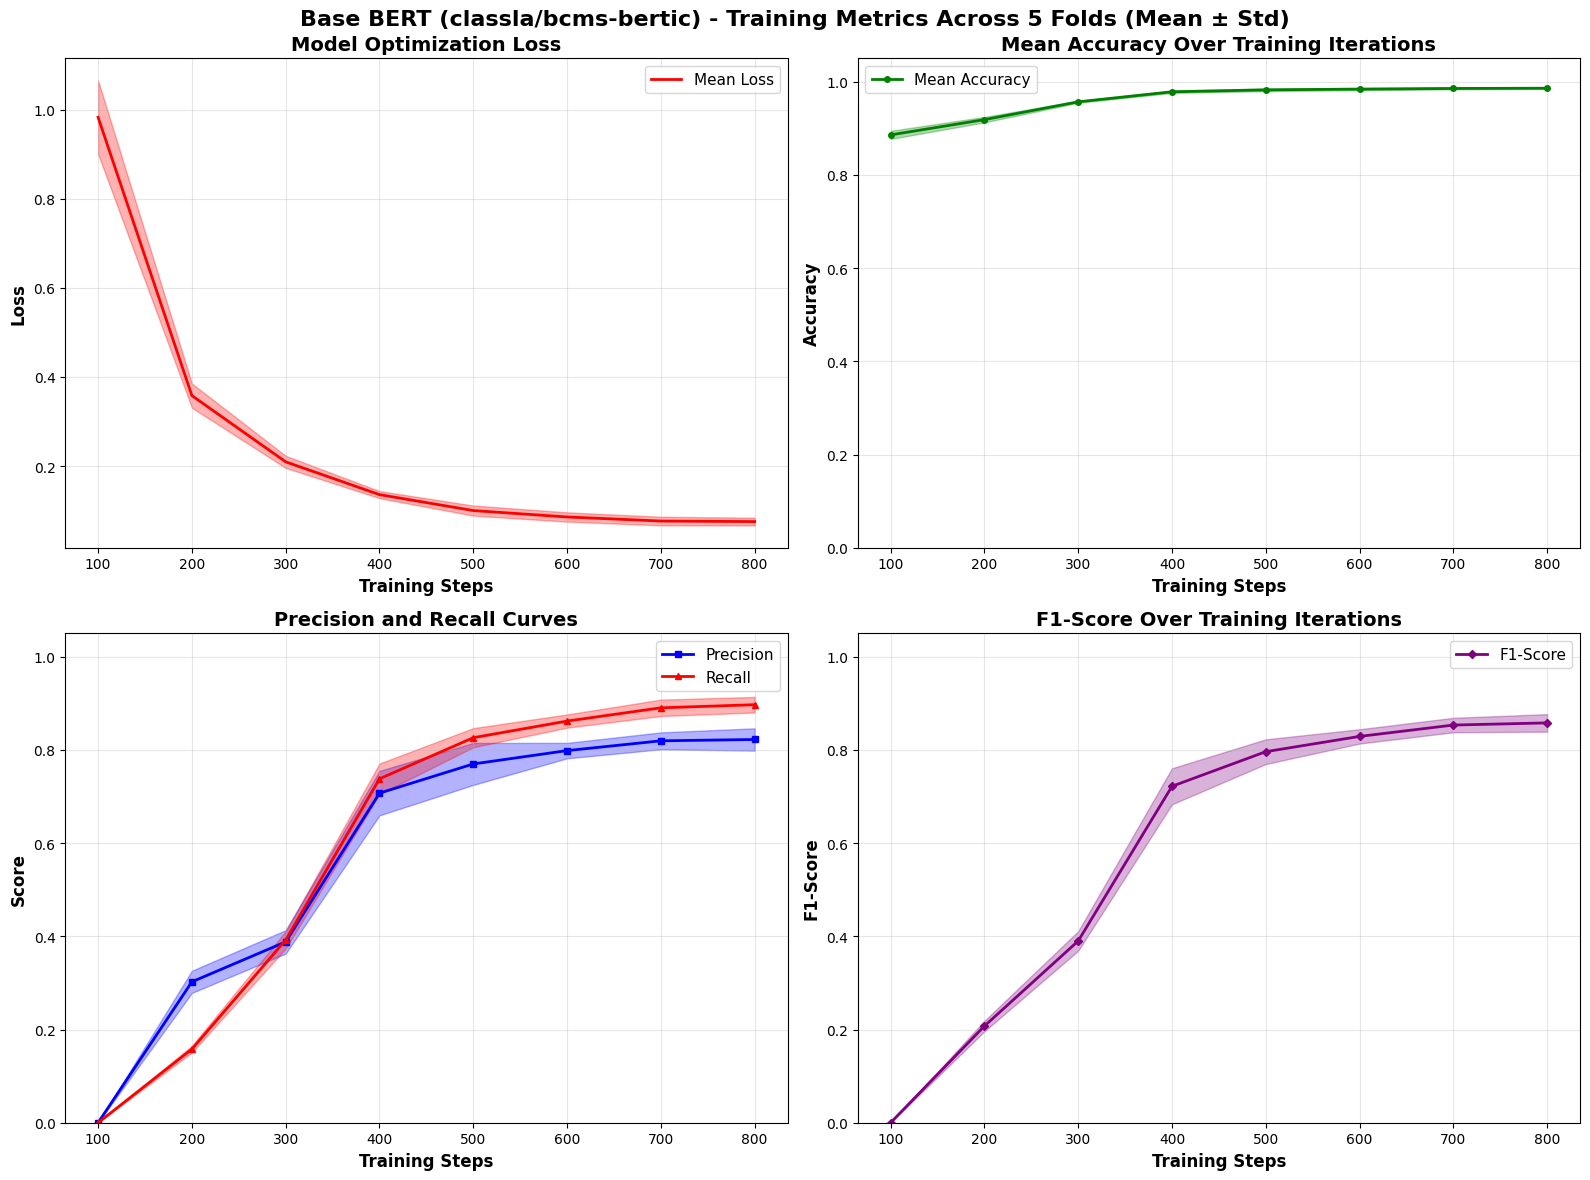

✅ Aggregate training metrics visualization displayed

📊 Aggregating per-class metrics...

AGGREGATING PER-CLASS METRICS ACROSS 5 FOLDS

Base BERT (classla/bcms-bertic) - Aggregated Classification Report (Mean ± Std)

Label                           Precision          Recall        F1-Score      Support
-------------------------------------------------------------------------------------
B-CASE_NUMBER               1.0000±0.0000   0.4574±0.1381   0.6148±0.1358         45±1
B-COURT                     0.9536±0.0120   0.9563±0.0377   0.9546±0.0211         99±2
B-CRIMINAL_ACT              0.9203±0.0329   0.9544±0.0247   0.9368±0.0256       204±14
B-DECISION_DATE             0.7870±0.0888   0.9496±0.0347   0.8560±0.0473         79±3
B-DEFENDANT                 0.7036±0.1242   0.8541±0.0926   0.7572±0.0731       295±31
B-JUDGE                     0.8250±0.0457   0.7189±0.0604   0.7660±0.0370         95±2
B-PROCEDURE_COSTS           0.8484±0.0589   0.9300±0.0395   0.8868±0.0479         62±9
B

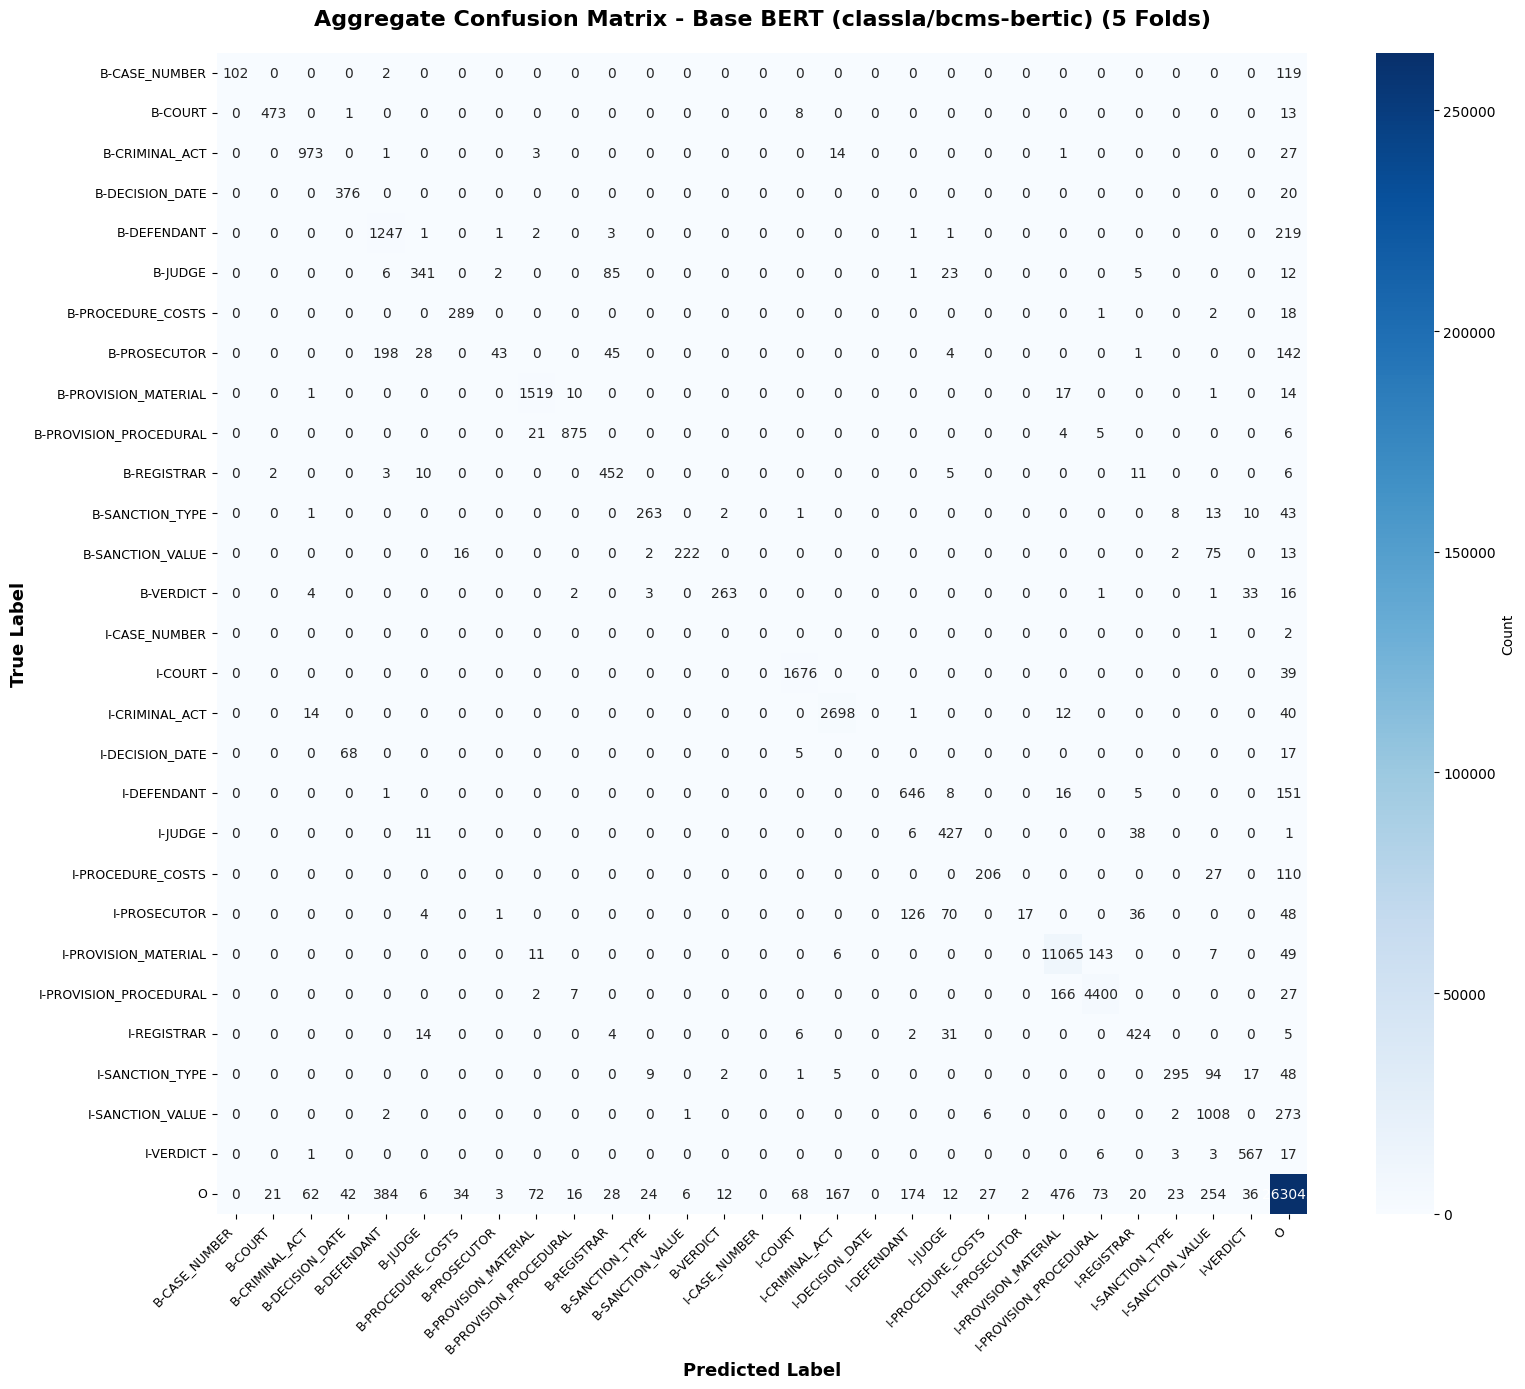

✅ Aggregate confusion matrix visualization displayed

📈 Aggregating F1 per class over iterations...

AGGREGATING F1 PER CLASS OVER ITERATIONS
⚠️  No per-class metrics found in training histories
ℹ️  This is normal if PerClassMetricsCallback didn't have access to model/eval_dataset during training
ℹ️  Per-class metrics are still available in the final classification report
ℹ️  Skipping F1 per class over iterations plot

✅ Aggregate report completed!

All visualizations displayed in notebook above.
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd1d06090d0, execution_count=12 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd1d0756650, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=7097849d-14ca-4437-a937-b136dcf88229> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [12]:
# ============================================================================
# GENERATE COMPREHENSIVE AGGREGATE REPORT
# ============================================================================

print(f"\n{'='*80}")
print(f"GENERATING AGGREGATE REPORT ACROSS ALL {N_FOLDS} FOLDS")
print(f"{'='*80}")

# Create aggregate report with all visualizations displayed in notebook
aggregate_report = create_aggregate_report_across_folds(
    fold_results=fold_results,
    model_name="Base BERT (classla/bcms-bertic)",
    display=True
)

## 10. K-Fold Results Analysis and Summary

In [13]:
# ============================================================================
# K-FOLD RESULTS SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print(f"K-FOLD CROSS-VALIDATION RESULTS SUMMARY")
print(f"{'='*80}")

# Extract metrics from all folds
precisions = [result['precision'] for result in fold_results]
recalls = [result['recall'] for result in fold_results]
f1_scores = [result['f1'] for result in fold_results]
accuracies = [result['accuracy'] for result in fold_results]

# Calculate statistics
print(f"\n📊 PERFORMANCE METRICS ACROSS {N_FOLDS} FOLDS:")
print(f"{'='*50}")

print(f"\n🎯 PRECISION:")
print(f"  Mean: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"  Min:  {np.min(precisions):.4f} (Fold {np.argmin(precisions) + 1})")
print(f"  Max:  {np.max(precisions):.4f} (Fold {np.argmax(precisions) + 1})")

print(f"\n🎯 RECALL:")
print(f"  Mean: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"  Min:  {np.min(recalls):.4f} (Fold {np.argmin(recalls) + 1})")
print(f"  Max:  {np.max(recalls):.4f} (Fold {np.argmax(recalls) + 1})")

print(f"\n🎯 F1-SCORE:")
print(f"  Mean: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"  Min:  {np.min(f1_scores):.4f} (Fold {np.argmin(f1_scores) + 1})")
print(f"  Max:  {np.max(f1_scores):.4f} (Fold {np.argmax(f1_scores) + 1})")

print(f"\n🎯 ACCURACY:")
print(f"  Mean: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"  Min:  {np.min(accuracies):.4f} (Fold {np.argmin(accuracies) + 1})")
print(f"  Max:  {np.max(accuracies):.4f} (Fold {np.argmax(accuracies) + 1})")

# Individual fold results
print(f"\n📋 INDIVIDUAL FOLD RESULTS:")
print(f"{'='*50}")
for i, result in enumerate(fold_results, 1):
    print(f"Fold {i}: P={result['precision']:.4f}, R={result['recall']:.4f}, F1={result['f1']:.4f}, Acc={result['accuracy']:.4f}")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd1c8b8b750, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=c0ffd657-3287-4c75-859f-9b289f686a8d>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given


K-FOLD CROSS-VALIDATION RESULTS SUMMARY

📊 PERFORMANCE METRICS ACROSS 5 FOLDS:

🎯 PRECISION:
  Mean: 0.7698 ± 0.0450
  Min:  0.6822 (Fold 3)
  Max:  0.8119 (Fold 2)

🎯 RECALL:
  Mean: 0.8261 ± 0.0206
  Min:  0.7981 (Fold 1)
  Max:  0.8575 (Fold 2)

🎯 F1-SCORE:
  Mean: 0.7961 ± 0.0265
  Min:  0.7517 (Fold 3)
  Max:  0.8341 (Fold 2)

🎯 ACCURACY:
  Mean: 0.9824 ± 0.0028
  Min:  0.9779 (Fold 3)
  Max:  0.9860 (Fold 4)

📋 INDIVIDUAL FOLD RESULTS:
Fold 1: P=0.7852, R=0.7981, F1=0.7916, Acc=0.9812
Fold 2: P=0.8119, R=0.8575, F1=0.8341, Acc=0.9824
Fold 3: P=0.6822, R=0.8369, F1=0.7517, Acc=0.9779
Fold 4: P=0.7840, R=0.8271, F1=0.8050, Acc=0.9860
Fold 5: P=0.7854, R=0.8110, F1=0.7980, Acc=0.9843
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd1c9c006d0, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd1c8b8

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd1c4012550, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=db1eeb8f-3669-4ff3-b565-7bea6b3f47ac>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

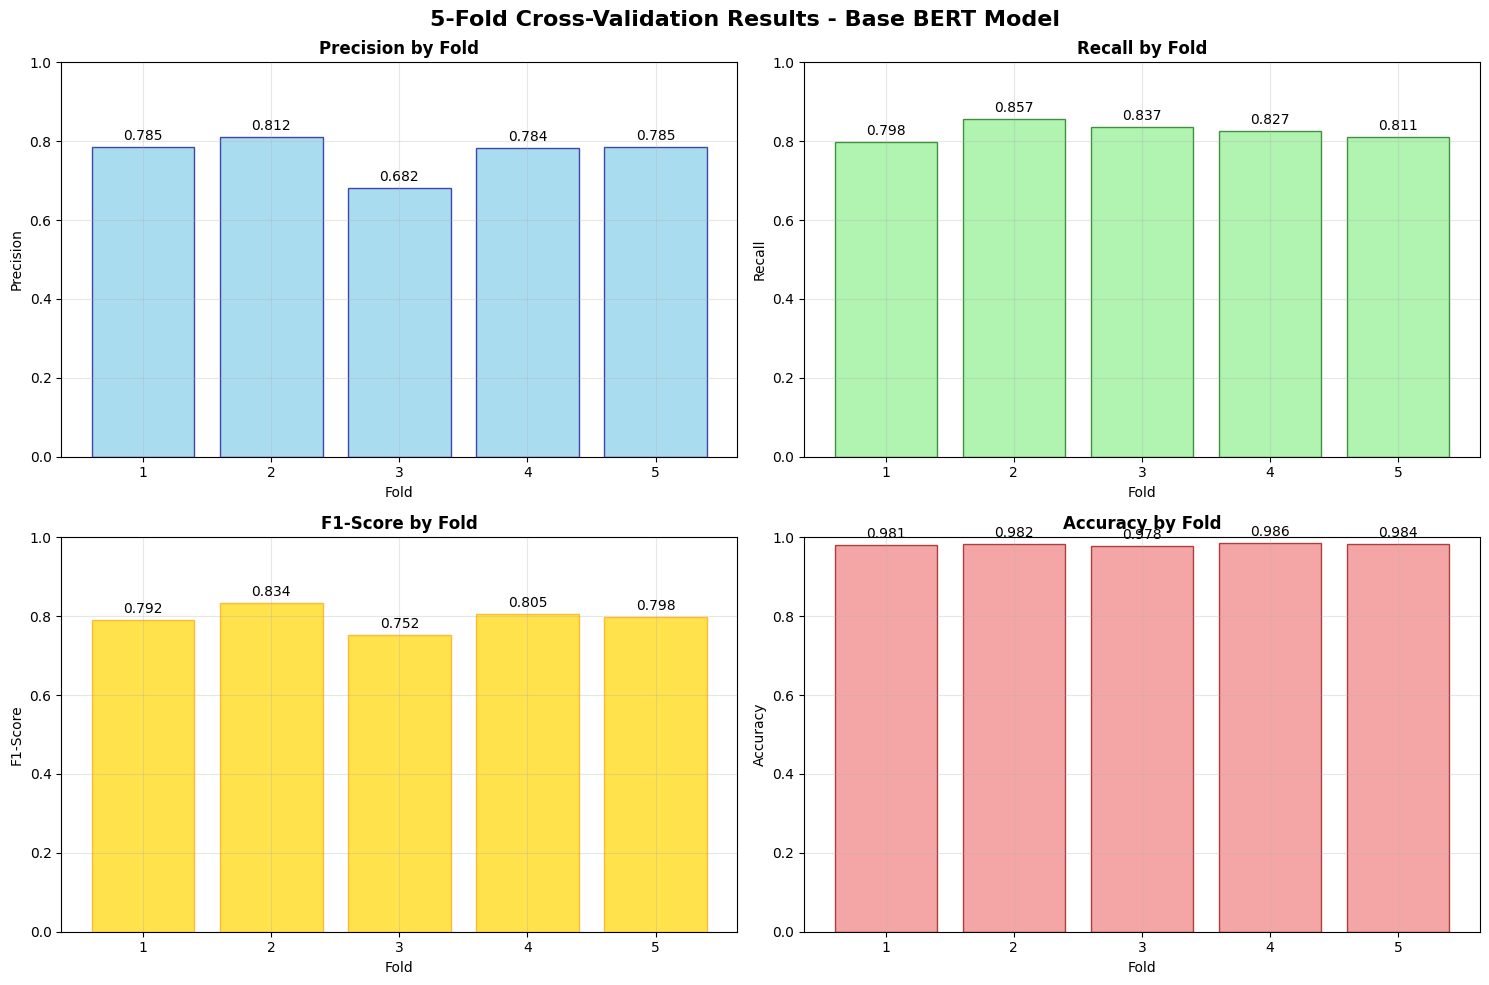

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd1d04bb3d0, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd1c4012550, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=db1eeb8f-3669-4ff3-b565-7bea6b3f47ac> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [14]:
# ============================================================================
# VISUALIZATION OF K-FOLD RESULTS
# ============================================================================

import matplotlib.pyplot as plt

# Create visualization of fold results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'{N_FOLDS}-Fold Cross-Validation Results - Base BERT Model', fontsize=16, fontweight='bold')

fold_numbers = list(range(1, N_FOLDS + 1))

# Precision plot
ax1.bar(fold_numbers, precisions, alpha=0.7, color='skyblue', edgecolor='navy')
ax1.set_title('Precision by Fold', fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Precision')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
for i, v in enumerate(precisions):
    ax1.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

# Recall plot
ax2.bar(fold_numbers, recalls, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
ax2.set_title('Recall by Fold', fontweight='bold')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Recall')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
for i, v in enumerate(recalls):
    ax2.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

# F1-Score plot
ax3.bar(fold_numbers, f1_scores, alpha=0.7, color='gold', edgecolor='orange')
ax3.set_title('F1-Score by Fold', fontweight='bold')
ax3.set_xlabel('Fold')
ax3.set_ylabel('F1-Score')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)
for i, v in enumerate(f1_scores):
    ax3.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

# Accuracy plot
ax4.bar(fold_numbers, accuracies, alpha=0.7, color='lightcoral', edgecolor='darkred')
ax4.set_title('Accuracy by Fold', fontweight='bold')
ax4.set_xlabel('Fold')
ax4.set_ylabel('Accuracy')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)
for i, v in enumerate(accuracies):
    ax4.text(i+1, v+0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd1d06525d0, raw_cell="# Box plot for metric distribution
fig, ax = plt.s.." store_history=True silent=False shell_futures=True cell_id=920bf948-27eb-4607-b85a-4cf337d8f37f>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

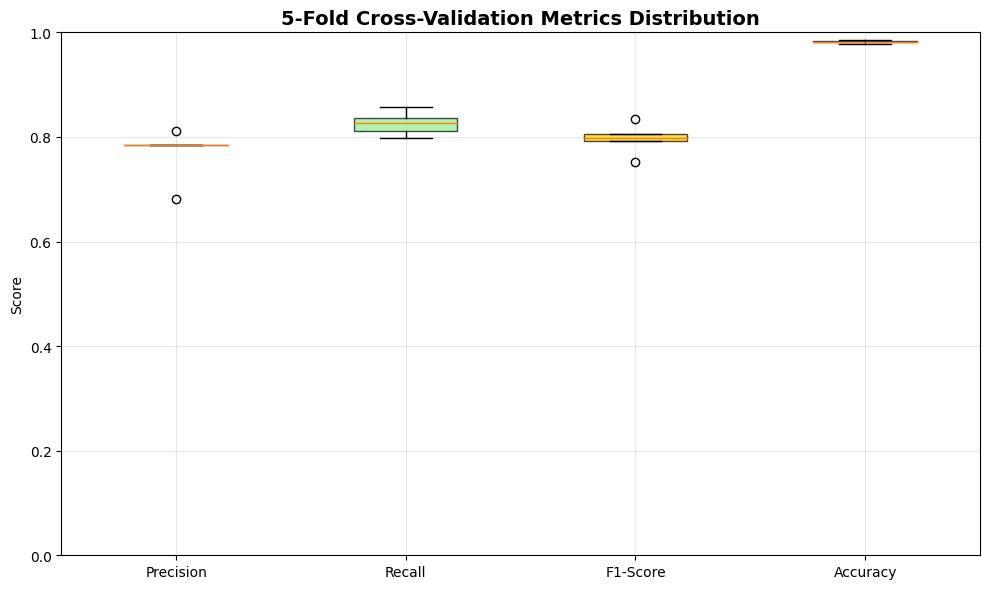

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd1c3f85a90, execution_count=15 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd1d06525d0, raw_cell="# Box plot for metric distribution
fig, ax = plt.s.." store_history=True silent=False shell_futures=True cell_id=920bf948-27eb-4607-b85a-4cf337d8f37f> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [15]:
# Box plot for metric distribution
fig, ax = plt.subplots(figsize=(10, 6))
metrics_data = [precisions, recalls, f1_scores, accuracies]
labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

box_plot = ax.boxplot(metrics_data, labels=labels, patch_artist=True)
colors = ['skyblue', 'lightgreen', 'gold', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title(f'{N_FOLDS}-Fold Cross-Validation Metrics Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 10. Save Results and Final Summary

In [16]:
# ============================================================================
# SAVE RESULTS TO FILE
# ============================================================================

import json
import pandas as pd
from datetime import datetime

# Create results summary
results_summary = {
    'experiment_info': {
        'model_name': MODEL_NAME,
        'n_folds': N_FOLDS,
        'total_examples': len(prepared_examples),
        'timestamp': datetime.now().isoformat(),
        'device': str(device)
    },
    'overall_metrics': {
        'precision': {
            'mean': float(np.mean(precisions)),
            'std': float(np.std(precisions)),
            'min': float(np.min(precisions)),
            'max': float(np.max(precisions))
        },
        'recall': {
            'mean': float(np.mean(recalls)),
            'std': float(np.std(recalls)),
            'min': float(np.min(recalls)),
            'max': float(np.max(recalls))
        },
        'f1_score': {
            'mean': float(np.mean(f1_scores)),
            'std': float(np.std(f1_scores)),
            'min': float(np.min(f1_scores)),
            'max': float(np.max(f1_scores))
        },
        'accuracy': {
            'mean': float(np.mean(accuracies)),
            'std': float(np.std(accuracies)),
            'min': float(np.min(accuracies)),
            'max': float(np.max(accuracies))
        }
    },
    'fold_results': [
        {
            'fold': result['fold'],
            'precision': float(result['precision']),
            'recall': float(result['recall']),
            'f1': float(result['f1']),
            'accuracy': float(result['accuracy'])
        }
        for result in fold_results
    ]
}

# Save results to JSON
results_file = f"{OUTPUT_DIR}/5fold_cv_results.json"
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ Results saved to: {results_file}")

# Create CSV for easy analysis
df_results = pd.DataFrame([
    {
        'Fold': result['fold'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1'],
        'Accuracy': result['accuracy']
    }
    for result in fold_results
])

# Add summary row
summary_row = {
    'Fold': 'Mean ± Std',
    'Precision': f"{np.mean(precisions):.4f} ± {np.std(precisions):.4f}",
    'Recall': f"{np.mean(recalls):.4f} ± {np.std(recalls):.4f}",
    'F1-Score': f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
    'Accuracy': f"{np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}"
}

df_results = pd.concat([df_results, pd.DataFrame([summary_row])], ignore_index=True)

csv_file = f"{OUTPUT_DIR}/5fold_cv_results.csv"
df_results.to_csv(csv_file, index=False)
print(f"✅ Results CSV saved to: {csv_file}")

# Display final summary table
print(f"\n📊 FINAL RESULTS TABLE:")
print(df_results.to_string(index=False))

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd1c3e59710, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=4dd028a1-5a7c-4fd3-a12a-047fc7537448>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

✅ Results saved to: /storage/models/bertic_base_5fold_cv/5fold_cv_results.json
✅ Results CSV saved to: /storage/models/bertic_base_5fold_cv/5fold_cv_results.csv

📊 FINAL RESULTS TABLE:
      Fold       Precision          Recall        F1-Score        Accuracy
         1        0.785231        0.798097        0.791612        0.981236
         2        0.811924         0.85747        0.834076        0.982384
         3        0.682189        0.836867        0.751653        0.977899
         4        0.784048        0.827132        0.805014        0.986016
         5        0.785443        0.810993        0.798013         0.98433
Mean ± Std 0.7698 ± 0.0450 0.8261 ± 0.0206 0.7961 ± 0.0265 0.9824 ± 0.0028
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fd1e815d090>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd1c3f4e190, execution_count=16 error_before_exec=None error_in_exec=None info=<ExecutionInfo objec

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given